## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.<br/>
Значение метрики RMSE на тестовой выборке должно быть не больше 48.  

Инструкция по выполнению проекта:

1. Загрузите данные и выполните их ресемплирование по одному часу.[](#step1)
    - Импортируем библиотеки [тут](#step1.1)
    - Загружаем данные [тут](#step1.2)
    - Ресемплируем [тут](#step1.3)
<br/>


2. Проанализируйте данные. [тут](#step2)<br/>


3. Обучите разные модели с различными гиперпараметрами.[](#step3)
Сделайте тестовую выборку размером 10% от исходных данных.
    - Делим выборки [тут](#step3.1)
    - Константная модель[тут](#step3.2)
    - Dummy модель[тут](#step3.2.1)
    - LinearRegression [тут](#step3.3)
    - СatBoost [тут](#step3.4)
        - GridSearchCV для СatBoost [тут](#step3.4.1)
        - Обучение СatBoost [тут](#step3.4.2)
            - [SymmetricTree](#step3.4.2.1)
            - [Depthwise](#step3.4.2.2)
            - [Lossguide](#step3.4.2.3)
    - LightGBM [тут](#step3.5)
        - GridSearchCV для LightGBM [тут](#step3.5.1)
        - Обучение LightGBM [тут](#step3.5.2)

4. [Проверьте данные на тестовой выборке и сделайте выводы.](#step4)

Описание данных.<br/>
Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

# <a id="step1"></a>

## Импортируем необходимые библиотеки<a id="step1.1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

import time
pd.set_option('display.precision',3)

import warnings
warnings.filterwarnings('ignore')

auto-scrolling block

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Загрузка данных<a id="step1.2"></a>

In [3]:
try:
    
    df = pd.read_csv('C:/Users/timur/Я.Практикум/Проекты/Data Science/Отредактировать/12. Временные ряды в такси/taxi.csv',
                     index_col=[0], parse_dates=[0])
    
except:
    
    df = pd.read_csv('/datasets/taxi.csv',
                     index_col=[0], parse_dates=[0])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.sort_index(inplace=True)

In [6]:
df.index.is_monotonic

True

## Ресемплирование<a id="step1.3"></a>

In [7]:
df = df.resample('1H').sum()

# Анализ данных<a id="step2"></a>

In [8]:
df.head(15)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


In [9]:
df.tail()

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


In [10]:
df['num_orders'].describe()

count    4416.000
mean       84.423
std        45.024
min         0.000
25%        54.000
50%        78.000
75%       107.000
max       462.000
Name: num_orders, dtype: float64

In [11]:
df[df['num_orders'] == 0]

,num_orders
datetime,
2018-04-06 06:00:00,0


In [12]:
df[df['num_orders'] == 462]

,num_orders
datetime,
2018-08-20 02:00:00,462


In [13]:
decomposed = seasonal_decompose(df['num_orders'])

In [14]:
decomposed_month = seasonal_decompose(df['2018-08-01':'2018-08-31']['num_orders'])
decomposed_week = seasonal_decompose(df['2018-08-20':'2018-08-26']['num_orders'])

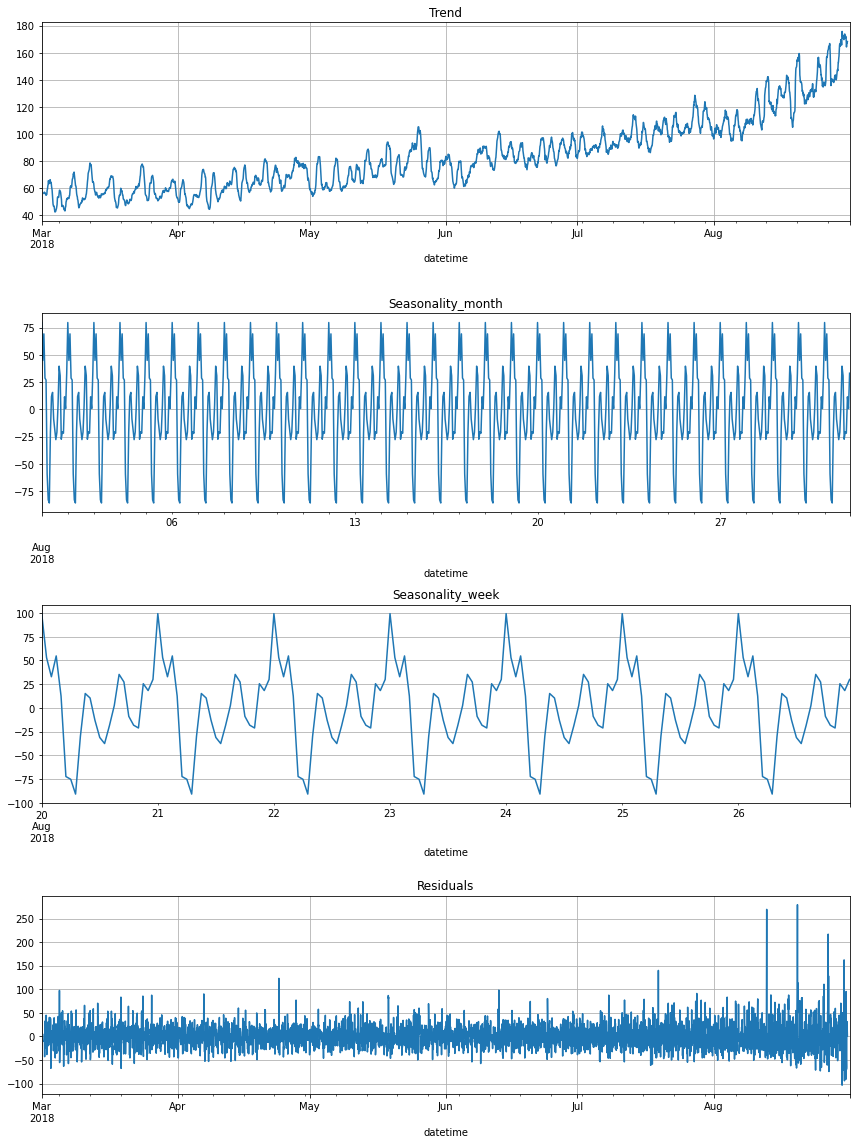

In [15]:
plt.figure(figsize=(12, 16))
plt.subplot(411)
decomposed.trend.plot(ax=plt.gca(), grid=True)
plt.title('Trend')
plt.subplot(412)
decomposed_month.seasonal.plot(ax=plt.gca(), grid=True)
plt.title('Seasonality_month')
plt.subplot(413)
decomposed_week.seasonal.plot(ax=plt.gca(), grid=True)
plt.title('Seasonality_week')
plt.subplot(414)
decomposed.resid.plot(ax=plt.gca(), grid=True)
plt.title('Residuals')
plt.tight_layout()

In [16]:
def make_features(data, max_lag, rolling_mean_size):
    enrich_df = data.copy()
    enrich_df['month'] = data.index.month
    enrich_df['day'] = data.index.day
    enrich_df['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        enrich_df['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    enrich_df['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return enrich_df

ndf = make_features(df, 170, 5)

In [17]:
ndf.dropna(inplace=True)

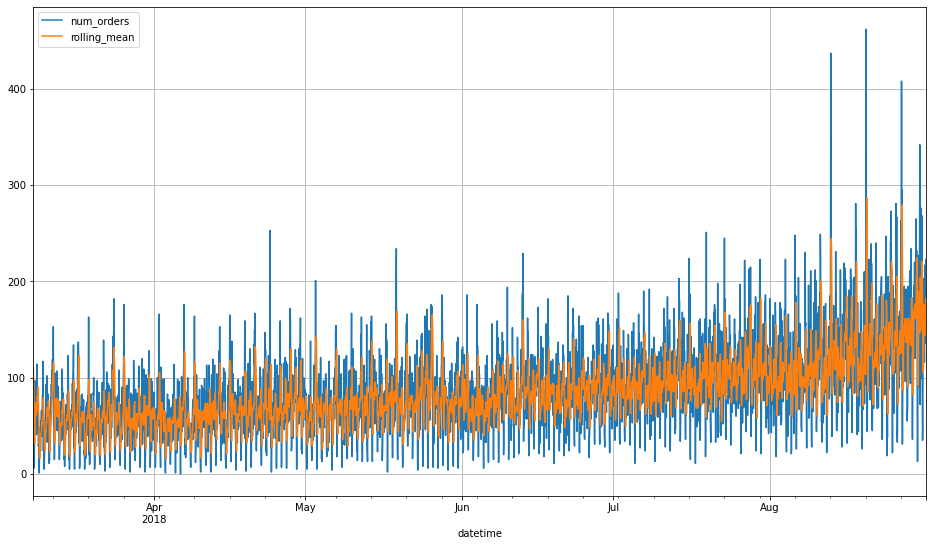

In [18]:
ndf[['num_orders', 'rolling_mean']].plot(figsize=(16,9), grid=True)

У нас имеются данные за 6 полных месяцев. С 2018-03-01 00:00:00 по 2018-08-31 23:00:00.<br/>
Виден стабильно растущий тренд и устойчивая дневная сезонность. <br/>
Максимум дневной сезонности - полночь, сразу после - резкое падение в минимум.<br/>
Мы серьёзно расширили набор фичей за счет добавления: 
    1. календаных признаков(число, месяц и день недели);
    2. отстающих значений(лаги за 170 предыдущих часов);
    3. скользящего среднего.

# Обучение моделей <a id="step3"></a>
## Деление выборок<a id="step3.1"></a>

In [19]:
train_full, test = train_test_split(ndf, shuffle=False, test_size=0.1)
train, valid = train_test_split(train_full, shuffle=False, test_size=0.1)

In [20]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-08 02:00:00 2018-07-29 07:00:00
2018-08-14 07:00:00 2018-08-31 23:00:00


In [21]:
train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']

test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

Создадим пустой список, в него будем добавлять показатели моделей в ходе работы.

In [22]:
final_table = []

## Константная модель<a id="step3.2"></a>

In [23]:
start_time = time.time()
pred_median = np.ones(len(test)) * train['num_orders'].median()
pred_time = time.time() - start_time
rmse = mean_squared_error(test['num_orders'], pred_median, squared=False)
print("RMSE:", rmse)

RMSE: 89.27114018868716


In [24]:
final_table.append(['Сonstant model', rmse, 0, pred_time])

In [25]:
test_target

datetime
2018-08-14 07:00:00     54
2018-08-14 08:00:00     91
2018-08-14 09:00:00    135
2018-08-14 10:00:00    155
2018-08-14 11:00:00    162
                      ... 
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: H, Name: num_orders, Length: 425, dtype: int64

In [26]:
ndf[ndf['lag_1'].index.isin(test_target.index)]['lag_1']

datetime
2018-08-14 07:00:00     45.0
2018-08-14 08:00:00     54.0
2018-08-14 09:00:00     91.0
2018-08-14 10:00:00    135.0
2018-08-14 11:00:00    155.0
                       ...  
2018-08-31 19:00:00    207.0
2018-08-31 20:00:00    136.0
2018-08-31 21:00:00    154.0
2018-08-31 22:00:00    159.0
2018-08-31 23:00:00    223.0
Freq: H, Name: lag_1, Length: 425, dtype: float64

## Dummy модель<a id="step3.2.1"></a>

In [27]:
start_time = time.time()
pred_median = ndf[ndf['lag_1'].index.isin(test_target.index)]['lag_1']
pred_time = time.time() - start_time
rmse = mean_squared_error(test['num_orders'], pred_median, squared=False)
print("RMSE:", rmse)

RMSE: 58.819724582830204


In [28]:
final_table.append(['Dummy model', rmse, 0, pred_time])

## Линейная регрессия <a id="step3.3"></a>

In [29]:
model = LinearRegression()
start_time = time.time()
model.fit(train_features, train_target)
learn_time = time.time() - start_time
start_time = time.time()
pred = model.predict(test_features)
pred_time = time.time() - start_time
rmse = mean_squared_error(test_target, pred, squared=False)
print('RMSE на тестовой выборке =', rmse)
print('Время затраченное на обучение модели LinearRegression -', learn_time,'секунд')

RMSE на тестовой выборке = 36.41860481288981
Время затраченное на обучение модели LinearRegression - 0.02894282341003418 секунд


In [30]:
final_table.append(['LinearRegression', rmse, learn_time, pred_time])

## CatBoost <a id="step3.4"></a>

In [31]:
!pip install catboost

In [32]:
from catboost import CatBoostRegressor

from sklearn.model_selection import GridSearchCV

In [33]:
cat_features = ['dayofweek']

## GridSearchCV для CatBoost <a id="step3.4.1"></a>

In [34]:
splits = TimeSeriesSplit(n_splits=5)

### Обучение модели <a id="step3.4.2"></a>

#### SymmetricTree(defolt) <a id="step3.4.2.1"></a>

In [35]:
start_time = time.time()

model = CatBoostRegressor(verbose=100, eval_metric='RMSE', learning_rate=0.01, max_depth=5, cat_features=cat_features)
model.fit(train_features, train_target)
learn_time = time.time() - start_time

0:	learn: 36.0592763	total: 158ms	remaining: 2m 37s
100:	learn: 24.5705430	total: 3.04s	remaining: 27.1s
200:	learn: 21.0836567	total: 5.91s	remaining: 23.5s
300:	learn: 19.8688642	total: 8.69s	remaining: 20.2s
400:	learn: 19.2673608	total: 11.4s	remaining: 17.1s
500:	learn: 18.8872880	total: 14.1s	remaining: 14s
600:	learn: 18.5849571	total: 16.8s	remaining: 11.1s
700:	learn: 18.3023336	total: 19.5s	remaining: 8.3s
800:	learn: 18.0483227	total: 22.1s	remaining: 5.5s
900:	learn: 17.7949886	total: 24.8s	remaining: 2.73s
999:	learn: 17.5161565	total: 27.4s	remaining: 0us


In [36]:
start_time = time.time()
pred = model.predict(test_features)
pred_time = time.time() - start_time
rmse = mean_squared_error(test_target, pred, squared=False)

final_table.append(['CatBoostRegressor(SymmetricTree)', rmse, learn_time, pred_time])

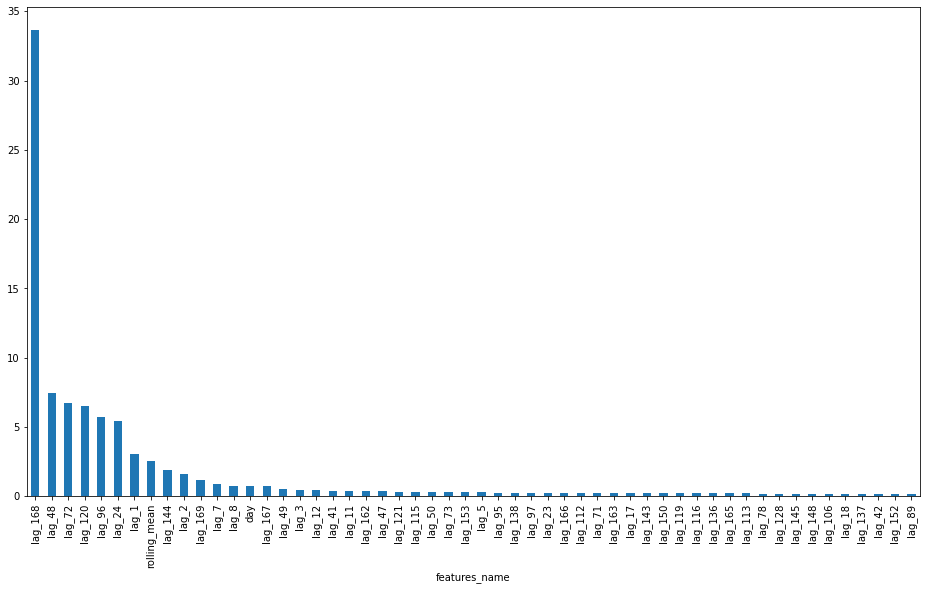

In [37]:
features_weight = pd.DataFrame({'features_name':train_features.columns,'weight':model.feature_importances_}).sort_values('weight', ascending=False).head(54)

features_weight.set_index('features_name')['weight'].plot(kind='bar', figsize=(16, 9))

Попробуем и другие алгоритмы поиска доступныt в кэтбусте

#### Depthwise <a id="step3.4.2.2"></a>

In [38]:
start_time = time.time()

model = CatBoostRegressor(verbose=100, eval_metric='RMSE', learning_rate=0.01, max_depth=5, grow_policy='Depthwise', cat_features=cat_features)
model.fit(train_features, train_target)
learn_time = time.time() - start_time

0:	learn: 36.0454332	total: 32.8ms	remaining: 32.7s
100:	learn: 23.9473493	total: 3.41s	remaining: 30.4s
200:	learn: 20.1266787	total: 6.74s	remaining: 26.8s
300:	learn: 18.6361941	total: 10s	remaining: 23.3s
400:	learn: 17.7847806	total: 13.3s	remaining: 19.9s
500:	learn: 17.2314251	total: 16.6s	remaining: 16.5s
600:	learn: 16.8085068	total: 19.7s	remaining: 13.1s
700:	learn: 16.4136048	total: 22.9s	remaining: 9.78s
800:	learn: 16.0971825	total: 26.1s	remaining: 6.5s
900:	learn: 15.7582810	total: 29.3s	remaining: 3.22s
999:	learn: 15.4719610	total: 32.4s	remaining: 0us


In [39]:
start_time = time.time()
pred = model.predict(test_features)
pred_time = time.time() - start_time
rmse = mean_squared_error(test_target, pred, squared=False)

final_table.append(['CatBoostRegressor(Depthwise)', rmse, learn_time, pred_time])

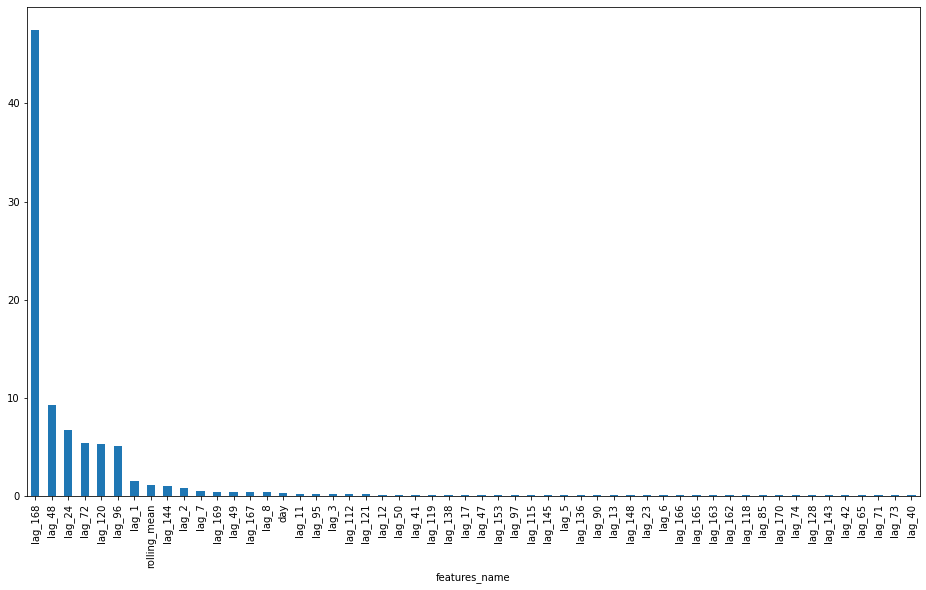

In [40]:
features_weight = pd.DataFrame({'features_name':train_features.columns,'weight':model.feature_importances_}).sort_values('weight', ascending=False).head(54)

features_weight.set_index('features_name')['weight'].plot(kind='bar', figsize=(16, 9))

#### Lossguide <a id="step3.4.2.3"></a>

In [41]:
start_time = time.time()

model = CatBoostRegressor(verbose=100, eval_metric='RMSE', learning_rate=0.01, max_depth=5, grow_policy='Lossguide', cat_features=cat_features)
model.fit(train_features, train_target)
learn_time = time.time() - start_time

0:	learn: 36.0496603	total: 120ms	remaining: 2m
100:	learn: 23.9969476	total: 12s	remaining: 1m 47s
200:	learn: 20.1761697	total: 24s	remaining: 1m 35s
300:	learn: 18.6311868	total: 35.8s	remaining: 1m 23s
400:	learn: 17.8075883	total: 47.4s	remaining: 1m 10s
500:	learn: 17.2506757	total: 58.4s	remaining: 58.1s
600:	learn: 16.8144121	total: 1m 9s	remaining: 45.8s
700:	learn: 16.4437511	total: 1m 19s	remaining: 33.9s
800:	learn: 16.0762462	total: 1m 30s	remaining: 22.4s
900:	learn: 15.7841917	total: 1m 40s	remaining: 11s
999:	learn: 15.4920227	total: 1m 50s	remaining: 0us


In [42]:
start_time = time.time()
pred = model.predict(test_features)
pred_time = time.time() - start_time
rmse = mean_squared_error(test_target, pred, squared=False)

final_table.append(['CatBoostRegressor(Lossguide)', rmse, learn_time, pred_time])

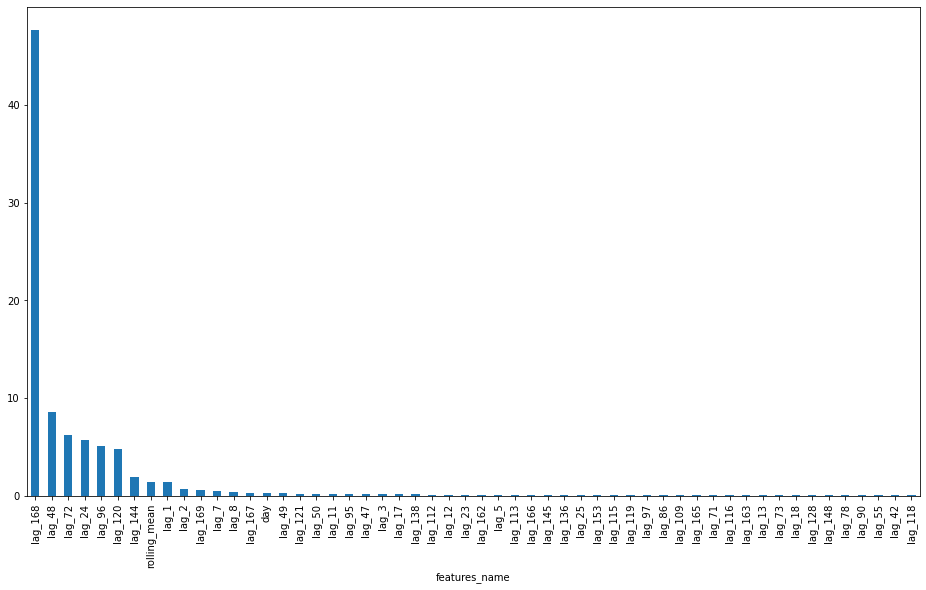

In [43]:
features_weight = pd.DataFrame({'features_name':train_features.columns,'weight':model.feature_importances_}).sort_values('weight', ascending=False).head(54)

features_weight.set_index('features_name')['weight'].plot(kind='bar', figsize=(16, 9))

### LightGBM <a id="step3.5"></a>

In [44]:
!pip install lightgbm

In [45]:
from lightgbm import LGBMRegressor

#### GridSearchCV для LightGBM<a id="step3.5.1"></a>

In [46]:
model = LGBMRegressor()

param = {'num_leaves': [250, 500, 750, 1000],
         'max_depth': range (1,13, 2),
         'learning_rate': [0.01, 0.05, 0.1, 0.25]}

grid = GridSearchCV(model, param, scoring='neg_root_mean_squared_error', cv=splits)
start_time = time.time()
grid.fit(train_features, train_target)
final_time = time.time() - start_time

grid.best_params_

{'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 250}

In [47]:
print('Время подбора гиперпараметров составило -', final_time, 'секунд')

Время подбора гиперпараметров составило - 91.61064887046814 секунд


#### Обучение модели <a id="step3.5.2"></a>

In [48]:
model = LGBMRegressor(learning_rate=0.05, max_depth=3, n_estimators=1000, num_leaves=250, metric = 'rmse')

start_time = time.time()
model.fit(train_features, train_target)
learn_time = time.time() - start_time

print('Время обучения составило -', learn_time,'секунд')

Время обучения составило - 0.5731275081634521 секунд


In [49]:
start_time = time.time()
pred = model.predict(test_features)
pred_time = time.time() - start_time
rmse = mean_squared_error(test_target, pred, squared=False)

final_table.append(['LGBMRegressor', rmse, learn_time, pred_time])

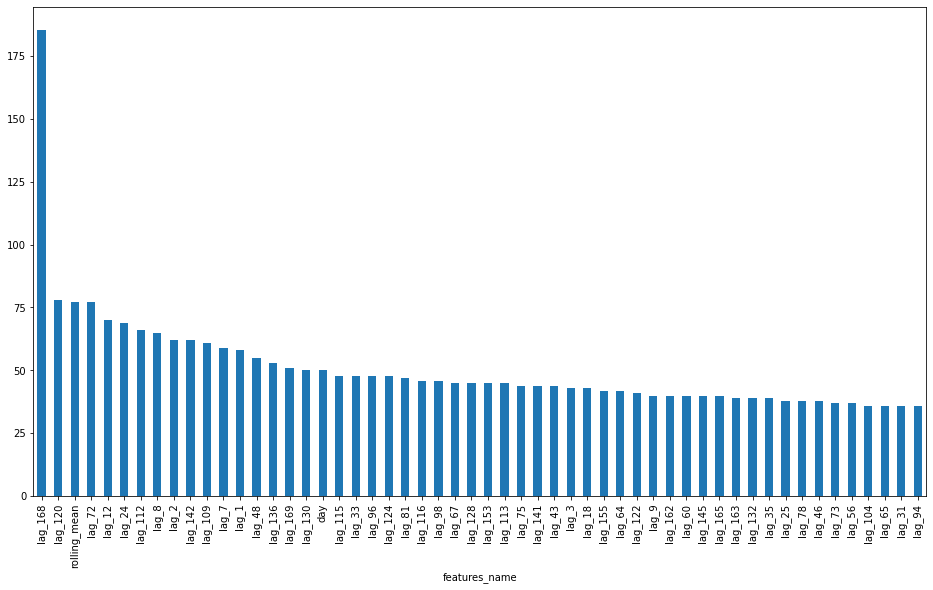

In [50]:
features_weight = pd.DataFrame({'features_name':train_features.columns,'weight':model.feature_importances_}).sort_values('weight', ascending=False).head(54)

features_weight.set_index('features_name')['weight'].plot(kind='bar', figsize=(16, 9))

Формируем итоговую таблицу

In [51]:
final_table = pd.DataFrame(final_table, columns=['model', 'rmse', 'learning_time', 'predict_time'])

# Выводы<a id="step4"></a>

In [52]:
final_table

,model,rmse,learning_time,predict_time
0,Сonstant model,89.271,0.000,1.002e-03
1,Dummy model,58.820,0.000,9.875e-04
2,LinearRegression,36.419,0.029,2.000e-03
3,CatBoostRegressor(SymmetricTree),43.393,27.677,1.000e-02
4,CatBoostRegressor(Depthwise),43.159,32.719,6.999e-03
5,CatBoostRegressor(Lossguide),43.179,110.889,7.995e-03
6,LGBMRegressor,41.861,0.573,9.002e-03


Получили очень интересное рапределение важности признаков.<br/>
Все бустинговые модели единогласно признали самыми информативными - признаки периодом в 24 часа (lag_24, lag_48 и т.д.). <br/>
Причём, самым важным фактором для всех моделей стал lag_168. Это потребность в транспорте неделю назад.<br/>
До того как пришла идея о 168ом часе, в рейтинге rmse побеждали бустинговые модели. <br/>
Но потом всё изменилось, простенькая линейная регрессия показала наилучшее rmse - 36.42, при необходимом 48.<br/>
Что же это, если не победа?